In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from Bio import SeqIO, pairwise2
from Bio.Align import substitution_matrices
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

### DeepLoc 1.0 dataset

In [59]:
def convert_names(name):
    conversion_dict = {
        'Nucleus': 'Nucleus',
        'Cytoplasm': 'Cytoplasm',
        'Extracellular': 'Extracellular',
        'Mitochondrion': 'Mitochondrion',
        'Cell.membrane': 'Cell membrane',
        'Endoplasmic.reticulum': 'Endoplasmic reticulum',
        'Plastid': 'Plastid',
        'Golgi.apparatus': 'Golgi apparatus',
        'Lysosome/Vacuole': 'Lysosome/Vacuole',
        'Peroxisome': 'Peroxisome'
    }
    return conversion_dict.get(name, name)


In [60]:
deeploc_1_raw = list(SeqIO.parse('data_files/deeploc_data.fasta', 'fasta'))

deeploc_1_data = []
for record in deeploc_1_raw:
    if 'test' not in record.description:
        acc_id = record.id
        location = convert_names(record.description.split()[1].split('-')[0])
        sequence = str(record.seq)
        deeploc_1_data.append((acc_id, location, sequence))

deeploc_1_dataframe = pd.DataFrame(deeploc_1_data, columns=['ACC', 'Location', 'Sequence'])

In [61]:
print(f"Number of records: {len(deeploc_1_dataframe)}")

Number of records: 11231


### Comapring with DeepLoc 2.0 dataset

In [62]:
deeploc_2_dataframe = pd.read_csv('data_files/multisub_5_partitions_unique.csv')

In [63]:
print(f"Number of records: {len(deeploc_2_dataframe)}")

Number of records: 28303


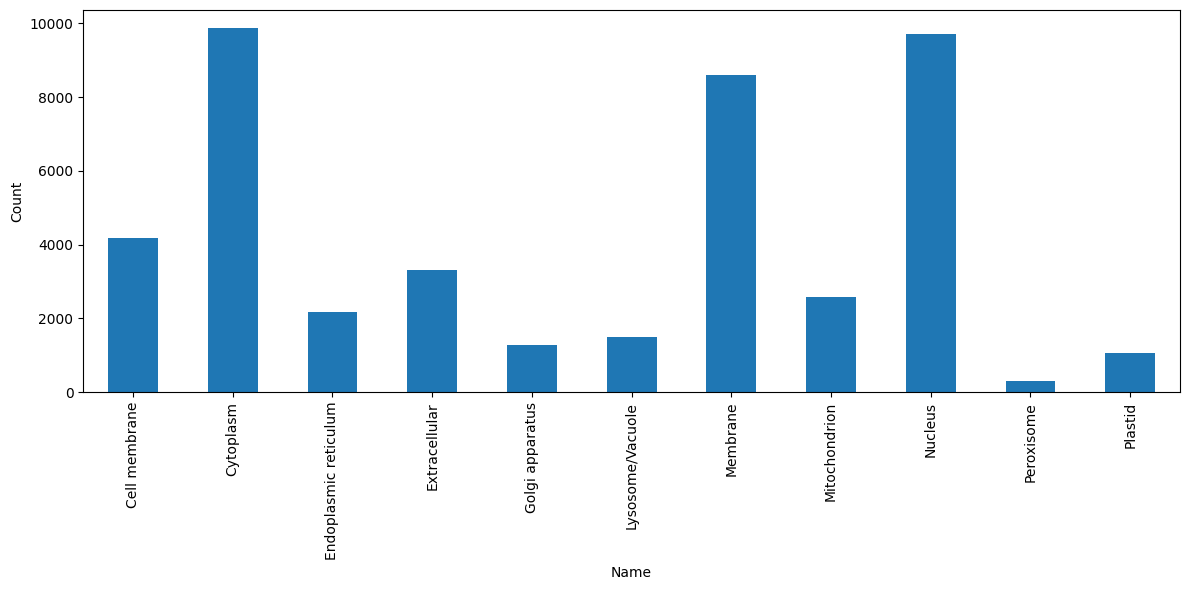

In [64]:
# DeepLoc 2.0 dataset, class distribution
count_ones = deeploc_2_dataframe.loc[:, 'Membrane':'Peroxisome'].eq(1).sum().sort_index()

plt.figure(figsize=(12, 6))
count_ones.plot(kind='bar', rot=90)
plt.xlabel('Name')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [65]:
# compare and remove exiting records
indices = deeploc_1_dataframe[deeploc_1_dataframe['ACC'].isin(deeploc_2_dataframe['ACC'])].index
deeploc_1_dataframe.drop(indices, inplace=True)
deeploc_1_dataframe = deeploc_1_dataframe[deeploc_1_dataframe['Location'] != 'Cytoplasm']

In [66]:
print(f"Number of records: {len(deeploc_1_dataframe)}")

Number of records: 669


In [67]:
def get_kingdom(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
    response = requests.get(url)
    if response.ok:
        for line in response.text.split("\n"):
            if line.startswith("OC"):
                parts = line[5:].split("; ")
                if len(parts) > 1:
                    return parts[1]
    return None

In [73]:
# convert to a common format
locations = ['Membrane', 'Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane', 'Mitochondrion', 'Plastid', 'Endoplasmic reticulum', 'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome']

# add binary indicator columns for each location
for location in locations:
    deeploc_1_dataframe[location] = (deeploc_1_dataframe['Location'] == location).astype(float)

# drop location column
deeploc_1_dataframe = deeploc_1_dataframe.drop(columns=['Location'])

# add kingdom column    
deeploc_1_dataframe['Kingdom'] = deeploc_1_dataframe['ACC'].apply(get_kingdom)

# add partition column
num_rows = len(deeploc_1_dataframe)
deeploc_1_dataframe['Partition'] = np.repeat(range(5), num_rows//5 + 1)[:num_rows]

# change the order
cols = ['Unnamed: 0', 'ACC', 'Kingdom', 'Partition'] + locations + ['Sequence']
deeploc_1_dataframe = deeploc_1_dataframe.reset_index().rename(columns={'index': 'Unnamed: 0'})[cols]

In [75]:
deeploc_1_dataframe.head()

,Unnamed: 0,ACC,Kingdom,Partition,Membrane,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome,Sequence
0,2,Q9NR71,Metazoa,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...
1,12,O23507,Viridiplantae,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MSRNLIYRRNRALCFVLILFCFPYRFGARNTPEAEQSTAKATQIIH...
2,19,Q9SD53,Viridiplantae,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MADKTDIISSSSDKASPPPPSAFRNYLSSGSKEPVLLLESAGKESC...
3,23,Q9XIM7,Viridiplantae,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MPMKSLRNDHGTLKAMIGSDFNELTIAAKNLATHAFTLTGLGFGTS...
4,27,D4AD53,Metazoa,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MTLLPGDNSDYDYSALSCASDTSFHPAFFPQRQAIKGVFYRRAQRL...


In [76]:
deeploc_2_dataframe.head()

,Unnamed: 0,ACC,Kingdom,Partition,Membrane,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome,Sequence
0,0,Q28165,Metazoa,4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...
1,1,Q86U42,Metazoa,4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDY...
2,2,Q0GA42,Metazoa,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MAAAAAAAAALGVRLRDCCSRGAVLLLFFSLSPRPPAAAAWLLGLR...
3,3,P82349,Metazoa,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MAAAAAAAAATEQQGSNGPVKKSMREKAVERRNVNKEHNSNFKAGY...
4,4,Q7L5N1,Metazoa,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MAAAAAAAAATNGTGGSSGMEVDAAVVPSVMACGVTGSVSVALHPL...


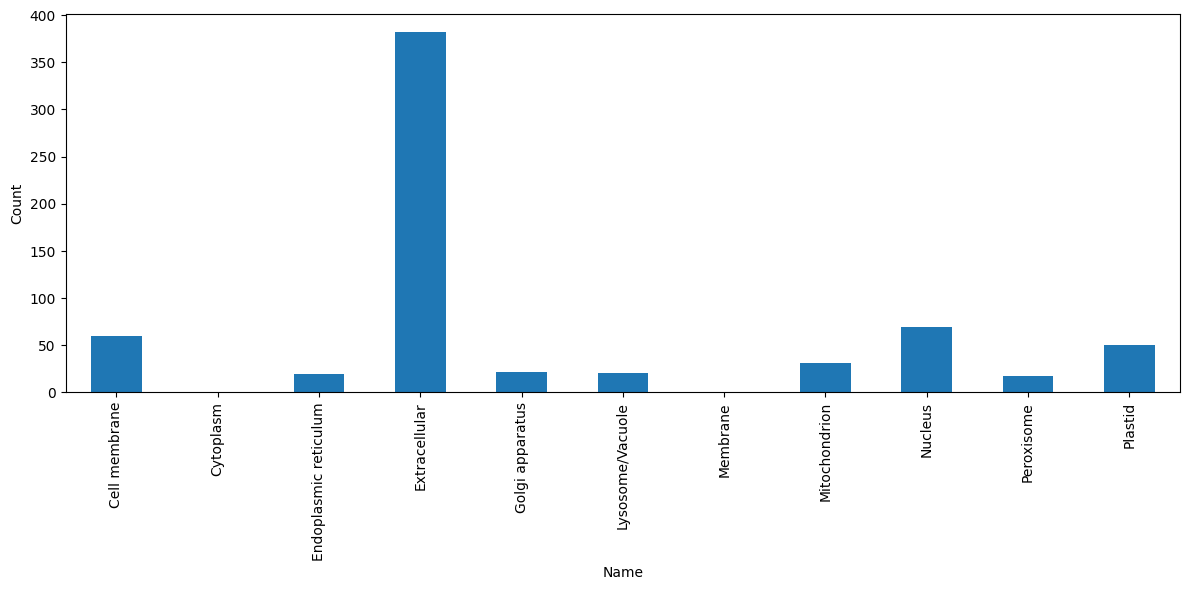

In [77]:
# DeepLoc 1.0 dataset (after dropping common data), class distribution
count_ones = deeploc_1_dataframe.loc[:, 'Membrane':'Peroxisome'].eq(1).sum().sort_index()

plt.figure(figsize=(12, 6))
count_ones.plot(kind='bar', rot=90)
plt.xlabel('Name')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Comapring with Independent testset

In [84]:
test_dataframe = pd.read_csv('data_files/hpa_testset.csv')

In [85]:
test_dataframe.head()

,sid,Cell membrane,Cytoplasm,Endoplasmic reticulum,Golgi apparatus,Lysosome/Vacuole,Mitochondrion,Nucleus,Peroxisome,Lengths,fasta
0,ENSP00000355743,0,0,0,0,0,0,1,0,496,MAAAAGPGAALSPRPCDSDPATPGAQSPKDDNEDNSNDGTQPSKRR...
1,ENSP00000429628,0,0,0,0,0,0,1,0,173,MAAAALRDPAQVPVAADLLTDHEEGYVTFEDVAVYFSQEEWRLLDD...
2,ENSP00000266544,0,0,0,0,0,1,0,0,377,MAAAAQSRVVRVLSMSRSAITAIATSVCHGPPCRQLHHALMPHGKG...
3,ENSP00000470652,0,0,0,1,0,0,0,0,410,MAAAAVGAGHGAGGPGAASSSGGAREGARVAALCLLWYALSAGGNV...
4,ENSP00000460751,0,0,0,0,0,0,1,0,163,MAAAAVTRGTPGENSHHLKIFLPKKLLECLPRCPLLPPERLRWNTN...


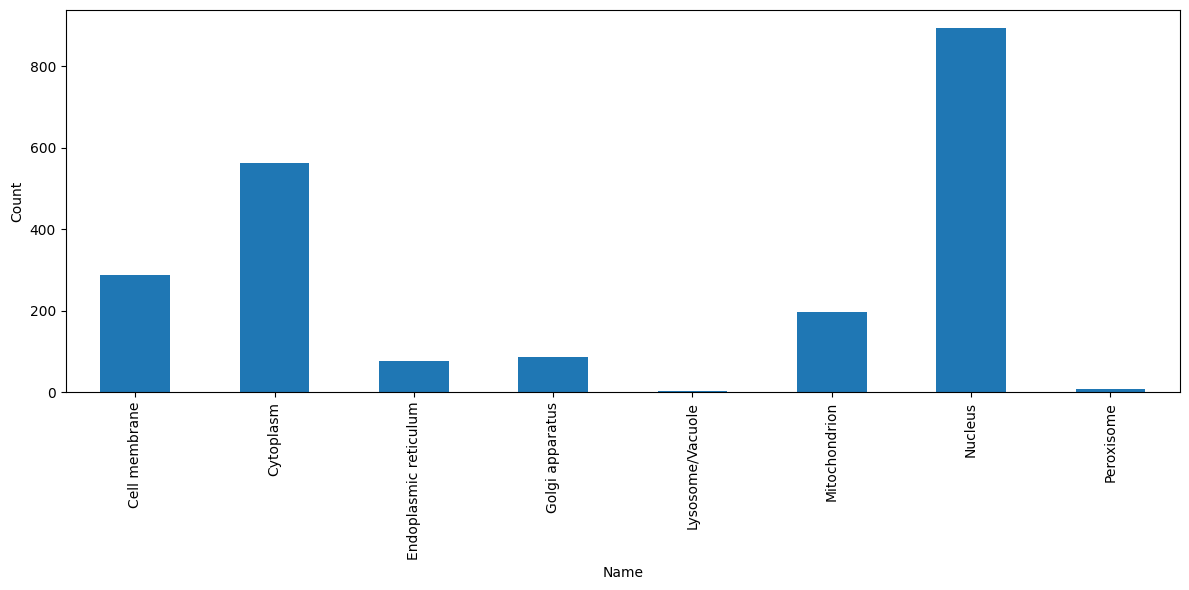

In [86]:
# testset, class distribution
count_ones = test_dataframe.loc[:, 'Cell membrane':'Peroxisome'].eq(1).sum().sort_index()

plt.figure(figsize=(12, 6))
count_ones.plot(kind='bar', rot=90)
plt.xlabel('Name')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [88]:
def process_data_part(member, filtered_dataframe, ind_dataframe, matrix, start_index, end_index):
    progress_bar = tqdm(total=end_index - start_index, desc=f"Processing data for member {member}")

    rows_to_remove = set()
    for index in range(start_index, end_index):
        new_data_row = filtered_dataframe.iloc[index]
        new_data_seq = new_data_row['Sequence']
        
        best_alignment_score_1 = pairwise2.align.globalds(new_data_seq, new_data_seq, matrix, -10, -0.5)[0].score
        
        for ind_index, ind_row in ind_dataframe.iterrows():
            ind_data_seq = ind_row['fasta']
            best_alignment_score_2 = pairwise2.align.globalds(ind_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score
            
            alignment_score = pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score
            similarity = alignment_score / max(best_alignment_score_1, best_alignment_score_2)
            
            if similarity > 0.25:
                print(f"row {index} similarity: {similarity*100}%")
                print(pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0])
                rows_to_remove.add(index)
                
            progress_bar.update(1)
    
    progress_bar.close()

    filtered_dataframe_part = filtered_dataframe.iloc[start_index:end_index].drop(list(rows_to_remove))
    filtered_dataframe_part.to_csv(f'data_{member}.csv', index=False)

def process_data(filtered_dataframe, ind_dataframe, matrix, member):
    num_members = 12  # Number of parallel threads or processes
    total_rows = filtered_dataframe.shape[0]
    rows_per_member = total_rows // num_members

    futures = []
    with ThreadPoolExecutor() as executor:
        for i in range(num_members):
            start_index = i * rows_per_member
            end_index = (i + 1) * rows_per_member if i < num_members - 1 else total_rows
            future = executor.submit(process_data_part, member + i, filtered_dataframe, ind_dataframe, matrix, start_index, end_index)
            futures.append(future)

In [89]:
matrix = substitution_matrices.load("BLOSUM62")
process_data(deeploc_1_dataframe, test_dataframe, matrix, 1)

Processing data for member 3:   0%|          | 0/55 [00:00<?, ?it/s]














































Processing data for member 3:   2%|▏         | 1/55 [00:02<00:10,  5.35it/s]













































Processing data for member 3:   4%|▎         | 2/55 [00:03<01:11,  1.35s/it]






















































Processing data for member 3:   5%|▌         | 3/55 [00:04<01:10,  1.36s/it]






























































Processing data for member 3:   7%|▋         | 4/55 [00:06<01:14,  1.46s/it]






















































Processing data for member 3:   9%|▉         | 5/55 [00:06<01:05,  1.32s/it]






















































Processing data for member 3:  11%|█         | 6/55 [00:07<00:52,  1.07s/it]






















































Processing data for member 3:  13%|█▎        | 7/55 [00:07<00:40,  1.18it/s]























